In [1]:
import sys
sys.path.append('/Users/jacky/Projects/tokendata/lib/python3.6/site-packages/')

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import requests

In [59]:
from collections import defaultdict

# ZRX Crowdsale Data

In [3]:
import etherscan.accounts as accounts

In [4]:
with open('key.json', 'r') as key_file:
    key = json.loads(key_file.read())['key']

In [5]:
# Get ZRX Crowdsale Transactions
api = accounts.Account(address="0xd4FD252d7D2C9479a8d616F510eAC6243B5DDdf9", api_key=key)

In [6]:
transactions = api.get_all_transactions()
df = pd.DataFrame(transactions)

page 1 added
page 2 added
page 3 added
Total number of transactions: 21650


In [7]:
# format data
df.value = df.value.astype(float)/ 1000000000000000000
df.timeStamp = pd.to_datetime(df.timeStamp, unit='s')
df.blockNumber = df.blockNumber.astype(int)
df.isError = df.isError.astype(int)

In [8]:
df = df.query('isError == 0')

In [23]:
# create dataframe with cumulative 'value' values
df_cumulative = df.copy()
df_cumulative.value = df_cumulative.value.cumsum()

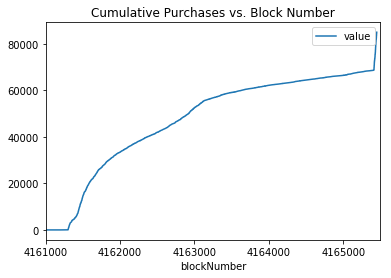

In [33]:
df_cumulative.plot(x='blockNumber',y='value', xlim=(4161000,4165500), xticks=range(4161000,4165500,1000))
plt.title('Cumulative Purchases vs. Block Number')
plt.show()

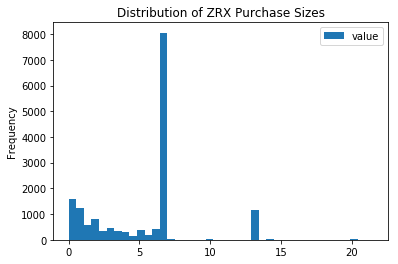

In [43]:
df.plot(y='value',kind="hist", bins=40)
plt.title('Distribution of ZRX Purchase Sizes')
plt.show()

In [54]:
import etherscan.tokens as tokens

In [57]:
api = tokens.Tokens(tokenname='TheDAO', api_key=key)

In [58]:
api.get_total_supply()

'11538165987024671407837618'

# Ethplorer Stuff

In [45]:
payload = {'apiKey':'freekey'}
r = requests.get('https://api.ethplorer.io/getTokenHistoryGrouped/0xe41d2489571d322189246dafa5ebde1f4699f498', params=payload)

# Etherscan Event Logs

In [16]:
LATEST_TX_BLOCK = 4473198
# NUM_BLOCKS = LATEST_TX_BLOCK - FIRST_TX_BLOCK 
# print(NUM_BLOCKS)

In [7]:
API_KEY = "A5M3YZ8VHWGBSHA9CHXJXKYBI37V67NQEP"
ZRX_ADDRESS = "0xe41d2489571d322189246dafa5ebde1f4699f498"
TRANSACTION_TYPE = "0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef"
API = 'https://api.etherscan.io/api?module=logs&action=getLogs'

In [217]:
def convert_data(data):
    return int(data,16) / 1e18

In [218]:
def get_latest_block():
    payload = {
            'apikey': API_KEY
        }
    r = requests.get('https://api.etherscan.io/api?module=proxy&action=eth_blockNumber', params=payload)
    return int(r.json()['result'],16)

In [232]:
def get_transactions(address, API_KEY):
    txns = []
    txn_hashes = set()
    curr_block = 0
    visited = set()
    latest_block = get_latest_block()
    counter = 0

    while curr_block < latest_block:
        stack = []

        # Track Progress
        if len(txns) >= counter:
            print("Transactions found: " + str(len(txns)))
            counter += 50000

        payload = {
            'fromBlock': str(curr_block),
            'toBlock': 'latest',
            'address': address,
            'topic0': TRANSACTION_TYPE,
            'apikey': API_KEY,
        }

        r = requests.get('https://api.etherscan.io/api?module=logs&action=getLogs', params=payload)


        for resp in r.json()['result']:
            if resp['transactionHash'] not in visited:
                txn = (resp['topics'][1], resp['topics'][2], convert_data(resp['data']), resp['transactionHash'])
                txns.append(txn)
                txn_hashes.add(resp['transactionHash'])
            if stack:
                if stack[-1] != resp['transactionHash']:
                    visited.add(stack.pop())
                    stack.append(resp['transactionHash'])
            else:
                stack.append(resp['transactionHash'])

        # clear stack
        while stack:
            visited.add(stack.pop())

        curr_block = int(resp['blockNumber'], 16) - 1
    return txns, txn_hashes


In [233]:
txns, txn_hashes = get_transactions(ZRX_ADDRESS, API_KEY)

Transactions found: 0
Transactions found: 50798
Transactions found: 100520
Transactions found: 150394


In [234]:
len(txns)

178024

In [237]:
len(txn_hashes)

160781

In [238]:
'0x8f099bcac1c66c6a5fbdeebd29ffadc1871af17bf20d89dc546dec585fe39d2c' in txn_hashes

True

In [236]:
print(txns[0])

('0x000000000000000000000000a3b2d1087bcebe59d188a23f75620612d967df72', '0x000000000000000000000000b88f384226d90ac329aba855cb3f71716d5e297a', 120250000.0, '0x053d78c7bd69bb5bcbd6c74944878b3c2007bde5fd159900df37de797373b994')


In [225]:
dist = {}
counter = 0
stack = []
for txn in txns:
    if len(stack) > 10:
        stack.pop()
    stack.append(txn[3])
    counter += 1
    
    f = txn[0]
    t = txn[1]
    amount = txn[2]
    
    if f in dist:
        dist[f] -= amount

    if t not in dist:
        dist[t] = 0
    dist[t] += amount
    
    if counter > 1000 and sum([dist[k] for k in dist]) > 1000000001:
        print(sum([dist[k] for k in dist]))
        print(counter)
        print(stack)
        print(txn)
        break

1000000100.0000037
14031
['0x053d78c7bd69bb5bcbd6c74944878b3c2007bde5fd159900df37de797373b994', '0xc3a4feb5d07447da9e7e75cd61cfe8e164f4aeb7e7025705c2e14093aee6ac49', '0x29b3388ab8d2162cef0b4ca50e7c2bd7b5965880a08d219ca31365fd50052cfc', '0xfbc2d9c0c76f0fb2ab74114b2446b20afe8c0225c50051d40f46ca96ebec677e', '0xd6fb38ee5b30dcd9a60a6076c056e01a8860a5e151ac7a157bc3c090041b94a0', '0x5e86d73f7d702c35c683480a43b06419c95ca811d6480b9694c6834793d91e9f', '0x67ef939eb6c8272a1594716baba118b6cc27e54f42166af2ee270e0ddaa0fef8', '0xec9e3ab25a9e0e21abaac6f85b058259e9c8f4cd333327a7a65c0b7d8add398c', '0xad41e14f7f49c83462601ee940e8eaa0273d443385e91e7025728b2b5df16d6f', '0xd758b7221864c4c0b454a88b7739c96920a56f0452f89892abb5863b200875b7', '0xf16df91f7ea84ec7ca9099bda99c99f306bb11df337a2b39fb4a51762261031d']
('0x0000000000000000000000000088426a75ce67917f3eb1810f35ca1163783bc9', '0x0000000000000000000000008015027c35844bd4b4fee91597b14c1a034c4da6', 100.0, '0xf16df91f7ea84ec7ca9099bda99c99f306bb11df337a2b39fb4a5

In [227]:
'0x0000000000000000000000000088426a75ce67917f3eb1810f35ca1163783bc9' in dist

False

In [212]:
sum([dist[k] for k in dist])

99999999.9999991

In [ ]:
percent_dist = dist